## Variational inference
We will fit a simple 1D Bayesian linear regression with known variance. The likelihood is given by,
$$y \sim \mathcal{N}(w_0 + w_1x, 1),$$
and the prior is,
$$w_0, w_1 \sim N(0, I).$$


In [1]:
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm, multivariate_normal
import jax
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.bijections import Affine
from flowjax.distributions import StandardNormal
from flowjax.train.variational_fit import fit_to_variational_target, ElboLoss


# generate observed data
data_key = jr.PRNGKey(0)
w_0 = 0.5
w_1 = -0.5

n = 20
key, x_key, noise_key = jr.split(data_key, 3)
x = jr.uniform(x_key, shape=(n,)) * 4 - 2
y = w_0 + w_1 * x + jr.normal(noise_key, shape=(n,))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We can define our objective, via the unnormalised posterior distribution. This maps samples $w$ to a vector of unnormalised probabilites

In [2]:
def unormalized_posterior(w):
    likelihood = norm.logpdf(y, w[0] + x * w[1]).sum()
    prior = norm.logpdf(w).sum()  # Standard normal prior
    return (likelihood + prior).sum()


We define and fit the flow. Note that we set `invert=False`, which loosely speaking specifies that we prioritise faster `sample` and `sample_and_log_prob` methods for the flow, instead of a fast `log_prob` method. The evidence lower bound (ELBO) approximation is computed using the `sample_and_log_prob` method.

In [3]:
loss = ElboLoss(unormalized_posterior, num_samples=100)

key, flow_key, train_key = jr.split(key, 3)

flow = MaskedAutoregressiveFlow(
    flow_key,
    base_dist=StandardNormal((2,)),
    transformer=Affine(),
    invert=False
)

# Train the flow variationally
flow, losses = fit_to_variational_target(
    train_key,
    flow,
    loss,
    learning_rate=1e-3,
    steps=200
)

100%|██████████| 200/200 [00:02<00:00, 86.98it/s, loss=29.5] 


We can now visualise the learned posterior, here using contour plots to show the approximate (blue) and true (red) posterior

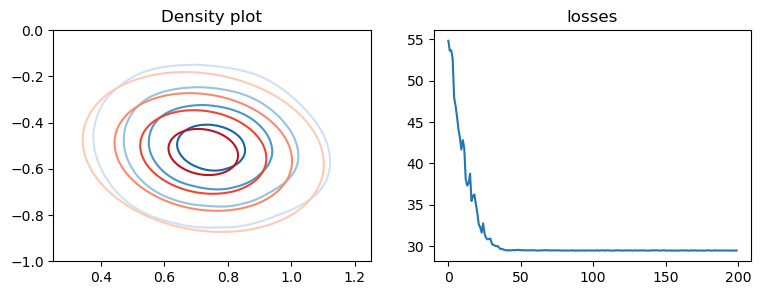

In [4]:
def plot_density(ax, density_fn, xmin=-5, xmax=5, ymin=-5, ymax=5, n=100, levels=None, cmap="Blues"):
    xvalues = jnp.linspace(xmin, xmax, n)
    yvalues = jnp.linspace(ymin, ymax, n)
    X, Y = jnp.meshgrid(xvalues, yvalues)

    points = jnp.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])

    log_prob = density_fn(points).reshape(n, n)
    prob = jnp.exp(log_prob)

    ax.contour(prob, levels=levels, extent=[xmin, xmax, ymin, ymax], origin="lower", cmap=cmap)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
axes[0].set_title('Density plot')

kwargs = dict(xmin=0.25, xmax=1.25, ymin=-1, ymax=0, levels=5)
plot_density(axes[0], flow.log_prob, cmap="Blues", **kwargs)

# True posterior for comparison
_x = jnp.vstack([jnp.ones_like(x), x]) # full design matrix
cov = jnp.linalg.inv(_x.dot(_x.T) + jnp.eye(2))
mean = cov.dot(_x).dot(y)
true_posterior_log_prob = lambda theta: multivariate_normal.logpdf(theta, mean, cov)
plot_density(axes[0], true_posterior_log_prob, cmap="Reds", **kwargs)

axes[1].set_title('losses')
axes[1].plot(losses)


We can visualise the regression fits

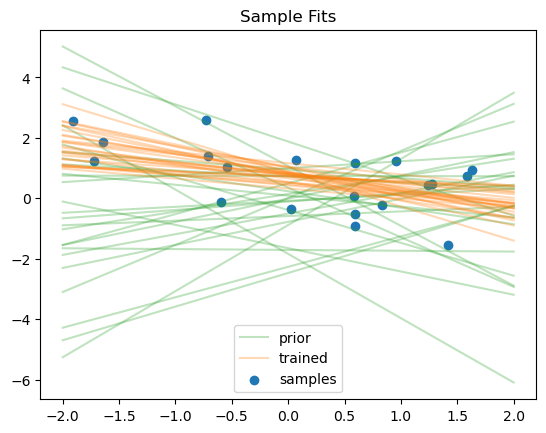

In [5]:
x_inspect = jnp.linspace(2, -2, n)
plots = [
    ('prior', StandardNormal((2,)), 'tab:green'),
    ('trained', flow, 'tab:orange'),
]
n_samples = 25

for label, flow, colour in plots:
    key, sample_key = jr.split(key)
    w = flow.sample(sample_key, (n_samples,))
    for ix, (w_0, w_1) in enumerate(w):
        y_inspect = w_0 + w_1 * x_inspect
        plt.plot(x_inspect, y_inspect, alpha=0.3, c=colour, label=label if ix == 0 else None)
    
plt.scatter(x, y, label='samples')
plt.title('Sample Fits')
plt.legend()
plt.show()